In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas
from tqdm import tqdm

import sys
sys.path.append("./modules")
from modules.Plot import setup_rc_params
setup_rc_params()

from modules import Potential, FOM, FOM_scipy
from modules.Matching import matching_using_least_squares
from modules.SpecialFunctions import analytic_phi

In [3]:
def RMSD(chi_test, chi_exact):
    # https://en.wikipedia.org/wiki/Root_mean_square_deviation
    return np.sqrt((1 / len(chi_test)) * np.sum((np.asarray(chi_test) - np.asarray(chi_exact))**2))

In [4]:
n = 1000
r, dr = np.linspace(0, 12, n, retstep=True)

Partial wave channel: 1S0


  0%|          | 0/150 [00:00<?, ?it/s]/Users/joshuamaldonado/Documents/GitHub/cs_greedy_emulator_josh/modules/SpecialFunctions.py:56: RuntimeWarning: invalid value encountered in multiply
  riccati_bessel_G = -rho * spherical_yn(l, rho)
100%|██████████| 150/150 [00:45<00:00,  3.27it/s]


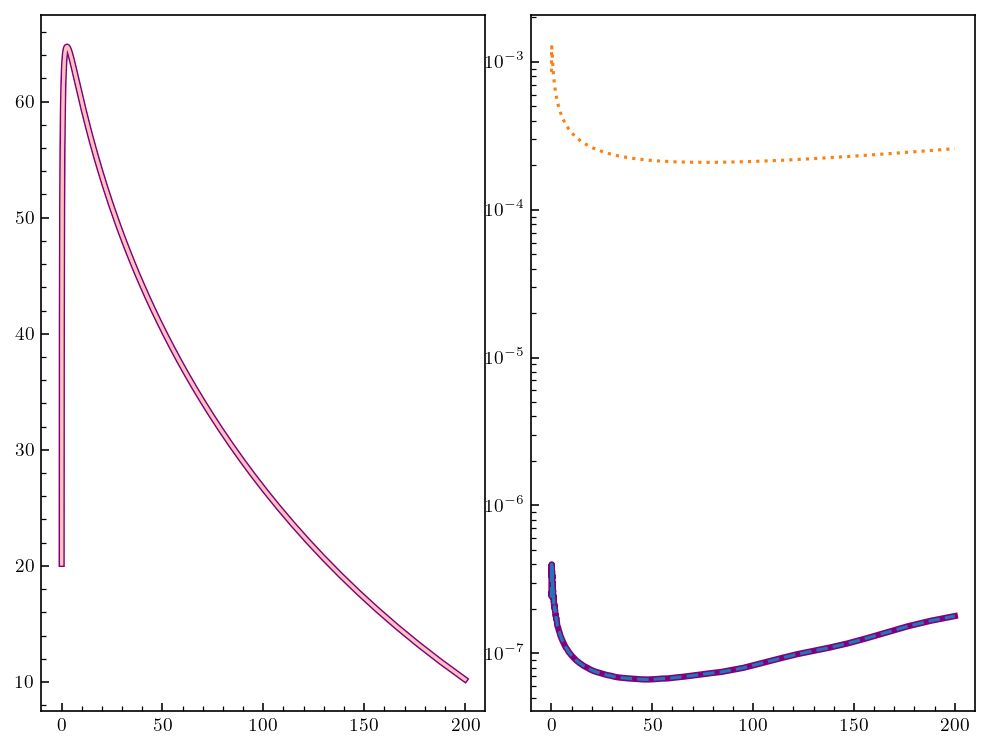


Partial wave channel: 1P1


  0%|          | 0/150 [00:00<?, ?it/s]/Users/joshuamaldonado/Documents/GitHub/cs_greedy_emulator_josh/modules/SpecialFunctions.py:56: RuntimeWarning: invalid value encountered in multiply
  riccati_bessel_G = -rho * spherical_yn(l, rho)
100%|██████████| 150/150 [04:44<00:00,  1.90s/it]


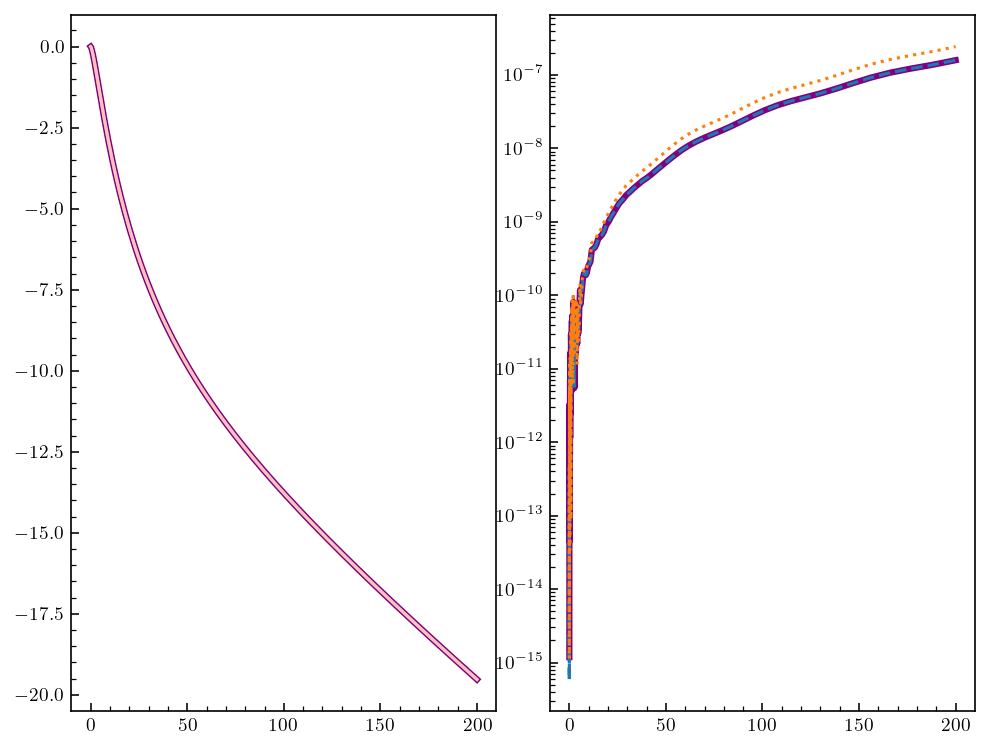


Partial wave channel: 1D2


  0%|          | 0/150 [00:00<?, ?it/s]/Users/joshuamaldonado/Documents/GitHub/cs_greedy_emulator_josh/modules/SpecialFunctions.py:56: RuntimeWarning: invalid value encountered in multiply
  riccati_bessel_G = -rho * spherical_yn(l, rho)
100%|██████████| 150/150 [08:03<00:00,  3.22s/it]


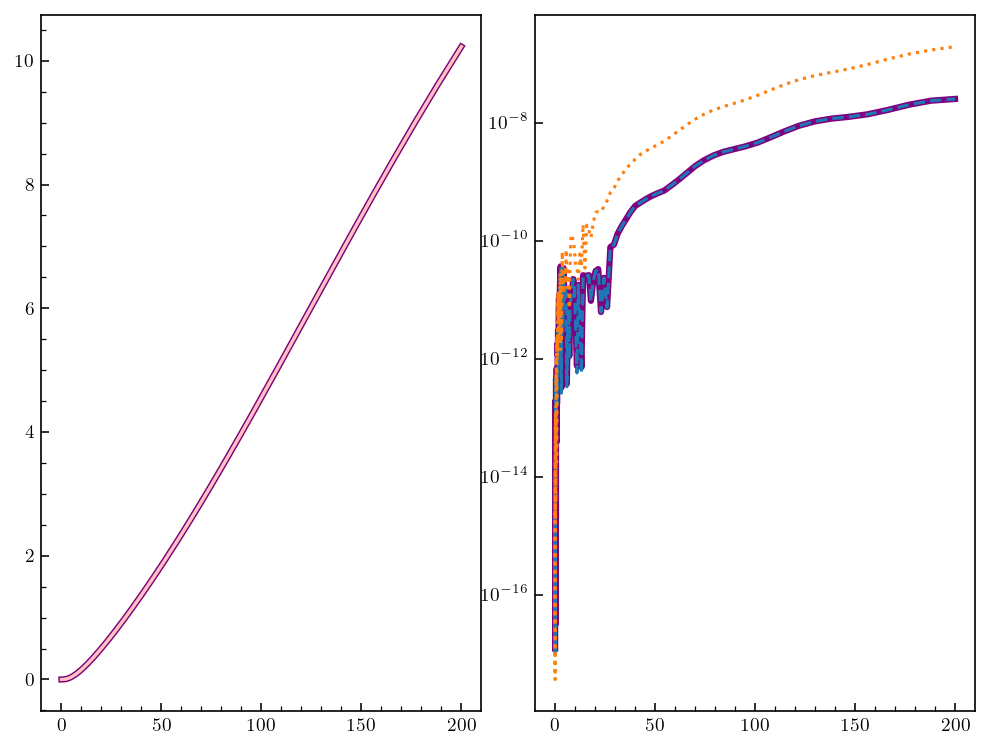


Partial wave channel: 1F3


  0%|          | 0/150 [00:00<?, ?it/s]/Users/joshuamaldonado/Documents/GitHub/cs_greedy_emulator_josh/modules/SpecialFunctions.py:56: RuntimeWarning: invalid value encountered in multiply
  riccati_bessel_G = -rho * spherical_yn(l, rho)
100%|██████████| 150/150 [10:49<00:00,  4.33s/it]


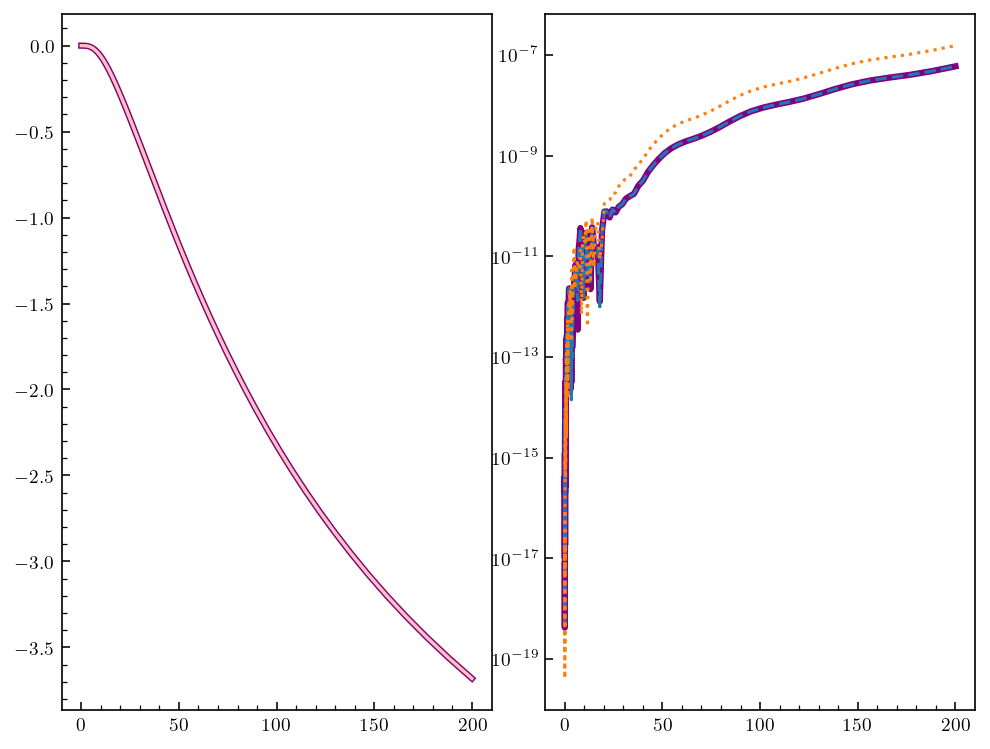


Partial wave channel: 1G4


  0%|          | 0/150 [00:00<?, ?it/s]/Users/joshuamaldonado/Documents/GitHub/cs_greedy_emulator_josh/modules/SpecialFunctions.py:56: RuntimeWarning: invalid value encountered in multiply
  riccati_bessel_G = -rho * spherical_yn(l, rho)
100%|██████████| 150/150 [13:45<00:00,  5.50s/it]


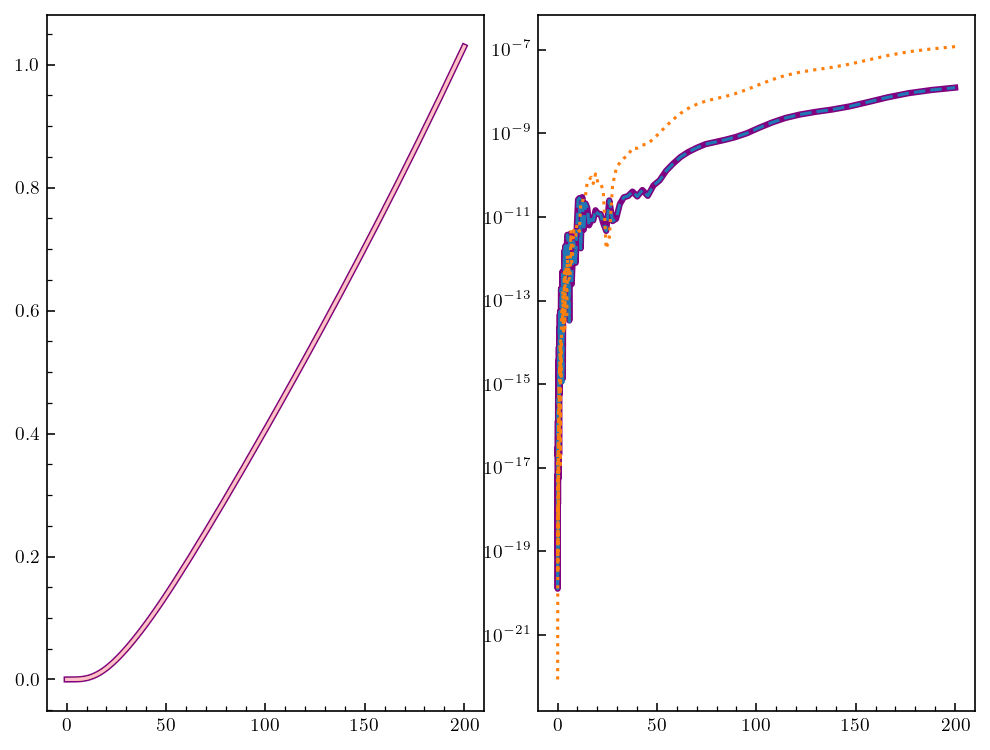

In [5]:
"""
Let's generate a figure of the errors.
"""

r_match = 11.5

partial_waves = [0, 1, 2, 3, 4]
energies = np.logspace(-2, 2, 150) * 2
# energies = np.sort(np.append(energies, 1e-3))

partial_wave_labels = []
unmatched_rk45 = []
unmatched_old = []
unmatched_all = []
matched_rk45 = []
matched_old = []
matched_all = []
delta_l_rk45 = []
delta_l_old = []
delta_l_all = []
unmatched_rk45_homo = []
unmatched_old_homo = []
unmatched_all_homo = []
matched_rk45_homo = []
matched_old_homo = []
matched_all_homo = []
delta_l_rk45_homo = []
delta_l_old_homo = []
delta_l_all_homo = []
for partial_wave in partial_waves:
    l = ll = j = partial_wave
    S = 0
    chiral_potential = Potential.Potential("chiral", r, l=l, ll=ll, j=j, S=S)
    
    theta = chiral_potential.default_theta.copy()
    print(f"Partial wave channel: {chiral_potential.channel.spectNotation}")
    partial_wave_labels.append(chiral_potential.channel.spectNotationTeX)
    
    temp_unmatched_rk45 = []
    temp_unmatched_old = []
    temp_unmatched_all = []
    temp_matched_rk45 = []
    temp_matched_old = []
    temp_matched_all = []
    temp_delta_l_rk45 = []
    temp_delta_l_old = []
    temp_delta_l_all = []
    temp_unmatched_rk45_homo = []
    temp_unmatched_old_homo = []
    temp_unmatched_all_homo = []
    temp_matched_rk45_homo = []
    temp_matched_old_homo = []
    temp_matched_all_homo = []
    temp_delta_l_rk45_homo = []
    temp_delta_l_old_homo = []
    temp_delta_l_all_homo = []
    for energy in tqdm(energies):
        old_FOM = FOM.MatrixNumerovSolver(chiral_potential, energy=energy / 2, use_ab=False)
        allatonce_FOM = FOM.MatrixNumerovSolver(chiral_potential, energy=energy / 2, use_ab=True)
        allatonce_FOM_homo = FOM.MatrixNumerovSolver(chiral_potential, energy=energy / 2, zeta=0, use_ab=True)
        solveivp_FOM = FOM_scipy.FOM(r, l, ll, j, S, potential_name="chiral",
                                     energy=energy / 2, atol=3e-14, rtol=3e-14, zeta=1)
        solveivp_FOM_homo = FOM_scipy.FOM(r, l, ll, j, S, potential_name="chiral",
                                          energy=energy / 2, atol=3e-14, rtol=3e-14, zeta=0)
        
        p = allatonce_FOM.p
        phi = analytic_phi(r, energy=energy, l=l)
        
        chi_rk45 = solveivp_FOM.solve(theta)
        chi_old = old_FOM.solve(theta)
        chi_allatonce_output = allatonce_FOM.solve(theta)
        chi_allatonce = chi_allatonce_output[:-2]
        a, b = chi_allatonce_output[-2:]
        
        psi_rk45 = solveivp_FOM_homo.solve(theta)
        # psi_old = old_FOM.solve(theta) + phi
        psi_allatonce_output_homo = allatonce_FOM_homo.solve(theta)
        psi_allatonce = psi_allatonce_output_homo[:-2]
        a_homo, b_homo = psi_allatonce_output_homo[-2:]
        
        
        match_output_rk45 = matching_using_least_squares(r, chi_rk45, p, l)
        matched_chi_rk45 = match_output_rk45["scaled_wave_function"]
        delta_rk45 = match_output_rk45["delta_l"]
        match_output_old = matching_using_least_squares(r, chi_old, p, l)
        matched_chi_old = match_output_old["scaled_wave_function"]
        delta_old = match_output_old["delta_l"]
        match_output_all = matching_using_least_squares(r, chi_allatonce, p, l)
        matched_chi_allatonce = match_output_all["scaled_wave_function"]
        delta_all = match_output_all["delta_l"]
        
        match_output_rk45_homo = matching_using_least_squares(r, psi_rk45, p, l, zeta=0)
        matched_psi_rk45_homo = match_output_rk45_homo["scaled_wave_function"]
        delta_rk45_homo = match_output_rk45_homo["delta_l"]
        match_output_all_homo = matching_using_least_squares(r, psi_allatonce, p, l, zeta=0)
        matched_psi_allatonce_homo = match_output_all_homo["scaled_wave_function"]
        delta_all_homo = match_output_all_homo["delta_l"]
        
        
        temp_unmatched_rk45.append(chi_rk45)
        temp_unmatched_old.append(chi_old)
        temp_unmatched_all.append(chi_allatonce)
        temp_matched_rk45.append(matched_chi_rk45)
        temp_matched_old.append(matched_chi_rk45)
        temp_matched_all.append(matched_chi_allatonce)
        temp_delta_l_rk45.append(delta_rk45)
        temp_delta_l_old.append(delta_old)
        temp_delta_l_all.append(delta_all)
        temp_unmatched_rk45_homo.append(psi_rk45)
        # temp_unmatched_old_homo.append(psi_old)
        temp_unmatched_all_homo.append(psi_allatonce)
        temp_matched_rk45_homo.append(matched_psi_rk45_homo)
        # temp_matched_old_homo.append(matched_psi_rk45_homo)
        temp_matched_all_homo.append(matched_psi_allatonce_homo)
        temp_delta_l_rk45_homo.append(delta_rk45_homo)
        # temp_delta_l_old_homo.append(delta_old_homo)
        temp_delta_l_all_homo.append(delta_all_homo)
    #
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(energies, np.degrees(temp_delta_l_all), color="purple", linewidth=3)
    ax[0].plot(energies, np.degrees(temp_delta_l_rk45))
    # ax[0].plot(energies, np.degrees(temp_delta_l_old))
    ax[0].plot(energies, np.degrees(temp_delta_l_all_homo))
    ax[0].plot(energies, np.degrees(temp_delta_l_rk45_homo), color="pink")
    
    
    ax[1].plot(energies, np.abs(np.degrees(np.asarray(temp_delta_l_rk45)) - np.degrees(np.asarray(temp_delta_l_all))), color="purple", linewidth=3)
    ax[1].plot(energies, np.abs(np.degrees(np.asarray(temp_delta_l_rk45)) - np.degrees(np.asarray(temp_delta_l_old))), linestyle="--")
    ax[1].plot(energies, np.abs(np.degrees(np.asarray(temp_delta_l_rk45_homo)) - np.degrees(np.asarray(temp_delta_l_all_homo))), linestyle=":")
    # ax[1].plot(energies, np.abs(np.degrees(np.asarray(temp_delta_l_rk45)) - np.degrees(np.asarray(temp_delta_l_old_homo))))
    ax[1].set_yscale("log")
    plt.show()
    
    
    unmatched_rk45.append(temp_unmatched_rk45)
    unmatched_rk45_homo.append(temp_unmatched_rk45_homo)
    unmatched_old.append(temp_unmatched_old)
    unmatched_all.append(temp_unmatched_all)
    unmatched_all_homo.append(temp_unmatched_all_homo)
    matched_rk45.append(temp_matched_rk45)
    matched_rk45_homo.append(temp_matched_rk45_homo)
    matched_old.append(temp_matched_old)
    matched_all.append(temp_matched_all)
    matched_all_homo.append(temp_matched_all_homo)
    delta_l_rk45.append(temp_delta_l_rk45)
    delta_l_rk45_homo.append(temp_delta_l_rk45_homo)
    delta_l_old.append(temp_delta_l_old)
    delta_l_all.append(temp_delta_l_all)
    delta_l_all_homo.append(temp_delta_l_all_homo)
    print("")
#

unmatched_rk45 = np.array(unmatched_rk45)
unmatched_rk45_homo = np.array(unmatched_rk45_homo)
unmatched_old = np.array(unmatched_old)
unmatched_all = np.array(unmatched_all)
unmatched_all_homo = np.array(unmatched_all_homo)
matched_rk45 = np.array(matched_rk45)
matched_rk45_homo = np.array(matched_rk45_homo)
matched_old = np.array(matched_old)
matched_all = np.array(matched_all)
matched_all_homo = np.array(matched_all_homo)
delta_l_rk45 = np.array(delta_l_rk45)
delta_l_rk45_homo = np.array(delta_l_rk45_homo)
delta_l_old = np.array(delta_l_old)
delta_l_all = np.array(delta_l_all)
delta_l_all_homo = np.array(delta_l_all_homo)


In [6]:
save_figure = False

dpi = 600
title_fontsize = 28
label_fontsize = tick_size = 28
tick_length = 4
linewidth = 5
e_min = -0.5
alpha = 0.6

# fig, ax = plt.subplots(3, 1, dpi=dpi, figsize=(8, 5 * 3))
fig, ax = plt.subplots(3, 1, dpi=dpi, figsize=(10, 5 * 3))

legend_waves = [0, 3, 1, 4, 2]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:red"]
all_plotted_delta_l = []
all_plotted_delta_l_RMSD = []
all_plotted_chi_RMSD = []
all_plotted_delta_l_homo = []
all_plotted_delta_l_homo_RMSD = []
all_plotted_psi_RMSD = []
for i in legend_waves:
    partial_wave_label =partial_wave_labels[i]
    color = colors[i]
    delta_l = delta_l_all[i, :]
    delta_l_homo = delta_l_all_homo[i, :]
    
    delta_RMSD = []
    unmatched_RMSD = []
    matched_RMSD = []
    delta_homo_RMSD = []
    unmatched_homo_RMSD = []
    matched_homo_RMSD = []
    for j in np.arange(len(energies)):
        delta_RMSD.append(np.abs(delta_l_all[i, j] - delta_l_rk45[i, j]))  # abs error
        unmatched_RMSD.append(RMSD(unmatched_all[i, j, :], unmatched_rk45[i, j, :]))  # RMSD
        matched_RMSD.append(RMSD(matched_all[i, j, :], matched_rk45[i, j, :]))  # RMSD
        
        delta_homo_RMSD.append(np.abs(delta_l_all_homo[i, j] - delta_l_rk45_homo[i, j]))  # abs error
        unmatched_homo_RMSD.append(RMSD(unmatched_all_homo[i, j, :], unmatched_rk45_homo[i, j, :]))  # RMSD
        matched_homo_RMSD.append(RMSD(matched_all_homo[i, j, :], matched_rk45_homo[i, j, :]))  # RMSD
    #
    ax[0].plot(energies, np.degrees(delta_l), 
               color=color, linewidth=linewidth, alpha=alpha)
    ax[1].plot(energies, np.degrees(delta_RMSD), 
               color=color, linewidth=linewidth, alpha=alpha, label=partial_wave_label)
    ax[2].plot(energies, matched_RMSD, 
               color=color, linewidth=linewidth, alpha=alpha)
    all_plotted_delta_l.append(delta_l)
    all_plotted_delta_l_RMSD.append(delta_RMSD)
    all_plotted_chi_RMSD.append(matched_RMSD)
    
    ax[0].plot(energies, np.degrees(delta_l_homo), 
               color=color, linewidth=linewidth, alpha=alpha, linestyle="--")
    ax[1].plot(energies, np.degrees(delta_homo_RMSD), 
               color=color, linewidth=linewidth, alpha=alpha, linestyle="--")
    ax[2].plot(energies, matched_homo_RMSD, 
               color=color, linewidth=linewidth, alpha=alpha, linestyle="--")
    all_plotted_delta_l_homo.append(delta_l_homo)
    all_plotted_delta_l_homo_RMSD.append(delta_homo_RMSD)
    all_plotted_psi_RMSD.append(matched_homo_RMSD)
#
all_plotted_delta_l = np.array(np.degrees(all_plotted_delta_l))
all_plotted_delta_l_RMSD = np.array(np.degrees(all_plotted_delta_l_RMSD))
all_plotted_chi_RMSD = np.array(all_plotted_chi_RMSD)
all_plotted_delta_l_homo = np.array(np.degrees(all_plotted_delta_l_homo))
all_plotted_delta_l_homo_RMSD = np.array(np.degrees(all_plotted_delta_l_homo_RMSD))
all_plotted_psi_RMSD = np.array(all_plotted_psi_RMSD)

ax[0].set_xlabel("")
ax[0].set_xticks([0, 50, 100, 150, 200], [""]*5)
ax[0].set_xlim(e_min, energies[-1])
ax[0].set_ylabel(r"Phase shift $\delta_\ell$ [deg]", fontsize=label_fontsize)
ax[0].tick_params(which='minor', length=tick_length)
ax[0].tick_params(which='major', length=tick_length * 2)
ax[0].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[0].xaxis.set_tick_params(labelsize=tick_size)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on x-axis
ax[0].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[0].yaxis.set_tick_params(labelsize=tick_size)
ax[0].yaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on y-axis
ax[0].yaxis.set_ticks_position('both')  # get log-ticks on left and right sides


ax[1].set_xlabel("")
ax[1].set_xticks([0, 50, 100, 150, 200], [""]*5)
ax[1].set_xlim(e_min, energies[-1])
ax[1].set_ylabel(r"Absolute Error in $\delta_\ell$ [deg]", fontsize=label_fontsize)
# ax[1].set_ylim(9e-14, 4e-6)
ax[1].set_ylim(9e-14, 8e-4)
ax[1].set_yscale("log")
ax[1].tick_params(which='minor', length=tick_length)
ax[1].tick_params(which='major', length=tick_length * 2)
ax[1].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[1].xaxis.set_tick_params(labelsize=tick_size)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on x-axis
ax[1].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[1].yaxis.set_tick_params(labelsize=tick_size)
ax[1].yaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on y-axis
ax[1].yaxis.set_ticks_position('both')  # get log-ticks on left and right sides
ax[1].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1.1, 10) * 0.1, numticks=10))
ax[1].yaxis.set_minor_formatter(plt.NullFormatter())
# ax[1].set_yticks([1e-13, 1e-11, 1e-9, 1e-7], 
#                  labels=[r"$10^{-13}$", r"$10^{-11}$", r"$10^{-9}$", r"$10^{-7}$"])
ax[1].set_yticks([1e-13, 1e-11, 1e-9, 1e-7, 1e-5], 
                 labels=[r"$10^{-13}$", r"$10^{-11}$", r"$10^{-9}$", r"$10^{-7}$", r"$10^{-5}$"])
ax[1].legend(loc="lower right",
             fontsize=label_fontsize - 2, 
             ncol=3,
             frameon=False,
             bbox_to_anchor=(1.03, -0.05))

ax[2].set_xlabel("Laboratory Energy [MeV]", fontsize=label_fontsize)
ax[2].set_xticks([0, 50, 100, 150, 200])
ax[2].set_xlim(e_min, energies[-1])
ax[2].set_ylabel(r"RMSD $\chi$ [fm$^{-1/2}$]", fontsize=label_fontsize)
# ax[2].set_ylim(1e-7, 6e-3)  # for the unmatched wave function
# ax[2].set_ylim(8e-14, 1e-6)
ax[2].set_ylim(8e-14, 8e-4)
ax[2].set_yscale("log")
ax[2].tick_params(which='minor', length=tick_length)
ax[2].tick_params(which='major', length=tick_length * 2)
ax[2].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[2].xaxis.set_tick_params(labelsize=tick_size)
ax[2].xaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on x-axis
ax[2].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[2].yaxis.set_tick_params(labelsize=tick_size)
ax[2].yaxis.set_minor_locator(AutoMinorLocator())  # get minor ticks on y-axis
ax[2].yaxis.set_ticks_position('both')  # get log-ticks on left and right sides
ax[2].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1.1, 10) * 0.1, numticks=10))
ax[2].yaxis.set_minor_formatter(plt.NullFormatter())
# ax[2].set_yticks([1e-13, 1e-11, 1e-9, 1e-7], 
#                  labels=[r"$10^{-13}$", r"$10^{-11}$", r"$10^{-9}$", r"$10^{-7}$"])
ax[2].set_yticks([1e-13, 1e-11, 1e-9, 1e-7, 1e-5], 
                 labels=[r"$10^{-13}$", r"$10^{-11}$", r"$10^{-9}$", r"$10^{-7}$", r"$10^{-5}$"])


# ax[0].plot(energies, np.degrees(delta_l) + 1e5, 
#            color="grey", linewidth=linewidth, alpha=alpha, label=r"$\zeta = 1$")
# ax[0].plot(energies, np.degrees(delta_l_homo) + 1e5, 
#            color="grey", linewidth=linewidth, alpha=alpha, linestyle="--", label=r"$\zeta = 0$")
# ax[0].set_ylim(-25, 69)
# ax[0].legend(loc="upper right",
#              fontsize=label_fontsize - 2, 
#              ncol=2,
#              frameon=False,
#              bbox_to_anchor=(1.0, 1.03))

ax[2].plot(energies, np.degrees(delta_l) + 1e5, 
           color="grey", linewidth=linewidth, alpha=alpha, label=r"$\zeta = 1$")
ax[2].plot(energies, np.degrees(delta_l_homo) + 1e5, 
           color="grey", linewidth=linewidth, alpha=alpha, linestyle="--", label=r"$\zeta = 0$")
ax[2].legend(loc="upper right",
             fontsize=label_fontsize - 2, 
             ncol=2,
             frameon=False,
             bbox_to_anchor=(1.0, 1.03))

x_percentage = 0.9
# y_percentage = 0.89
y_percentage = 0.76
ax[0].text(x_percentage, y_percentage, "(a)", fontsize=label_fontsize + 5, transform=ax[0].transAxes)
ax[1].text(x_percentage, y_percentage, "(b)", fontsize=label_fontsize + 5, transform=ax[1].transAxes)
ax[2].text(x_percentage, y_percentage, "(c)", fontsize=label_fontsize + 5, transform=ax[2].transAxes)

plt.tight_layout()
plt.subplots_adjust(hspace=0.0)
if save_figure:
    plt.savefig("./Figures/wave_function_error_plot.png", dpi=dpi)
    plt.savefig("./Figures/wave_function_error_plot.pdf", dpi=dpi)
    # don't forget to save the data for this plot
    labels = ["1S0", "1P1", "1D2", "1F3", "1G4"]
    for i, partial_wave in enumerate(partial_waves):
        label = labels[i]
        error_data = dict()
        error_data["partial wave"] = label
        error_data["lab energies"] = energies
        error_data["phase shifts"] = all_plotted_delta_l[i, :]
        error_data["phase shift errors"] = all_plotted_delta_l_RMSD[i, :]
        error_data["chi RMSD"] = all_plotted_chi_RMSD[i, :]
        error_data["phase shifts homogeneous"] = all_plotted_delta_l_homo[i, :]
        error_data["phase shift errors homogeneous"] = all_plotted_delta_l_homo_RMSD[i, :]
        error_data["psi RMSD"] = all_plotted_chi_RMSD[i, :]
        
        pandas.DataFrame.from_dict(data=error_data, orient="columns").to_csv(f"./Figures/{label}_data.csv", header=True)
    #
plt.show()


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_92918/3082964756.py:175: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
